<a href="https://colab.research.google.com/github/AbdelrahmanTamer11/Language-Translation-with-Transformers-/blob/main/language_translation_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import MarianMTModel, MarianTokenizer
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Load the MarianMT model and tokenizer for English to French translation
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

In [ ]:
# Function to clean and prepare the dataset from 'fra.txt'
def load_cleaned_data(file_path, num_samples=None):
    english_sentences = []
    french_sentences = []

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        if num_samples:
            lines = lines[:num_samples]  # Limit the number of samples if specified

        for line in lines:
            parts = line.split('\t')
            if len(parts) >= 2:
                english_sentence = parts[0].strip()  # English part
                french_sentence = parts[1].strip()  # French part
                english_sentences.append(english_sentence)
                french_sentences.append(french_sentence)

    return english_sentences, french_sentences

In [ ]:
# Load the cleaned data
file_path = '/kaggle/input/english-french-bilingual-sentence-pairs-232k/fra.txt'  # Specify the correct path to your data file
english_sentences, french_sentences = load_cleaned_data(file_path, num_samples=1000)


In [ ]:
# Tokenizing all sentences in advance
def tokenize_sentences(sentences, tokenizer, max_length=50):
    return tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=max_length)


In [ ]:
# Tokenize the training and validation data
train_size = int(0.8 * len(english_sentences))
train_english, val_english = english_sentences[:train_size], english_sentences[train_size:]
train_french, val_french = french_sentences[:train_size], french_sentences[train_size:]

train_encodings = tokenize_sentences(train_english, tokenizer)
train_labels = tokenize_sentences(train_french, tokenizer)["input_ids"]
val_encodings = tokenize_sentences(val_english, tokenizer)
val_labels = tokenize_sentences(val_french, tokenizer)["input_ids"]

train_loader = DataLoader(list(zip(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)), batch_size=8, shuffle=True)
val_loader = DataLoader(list(zip(val_encodings["input_ids"], val_encodings["attention_mask"], val_labels)), batch_size=8)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
# Training and evaluation
def train_and_evaluate_fixed_epochs(model, train_loader, val_loader):
    epochs = 5
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, val_loss = 0, 0
        correct_train, total_train = 0, 0
        correct_val, total_val = 0, 0

        # Training phase
        model.train()
        for input_ids, attention_mask, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            predicted = outputs.logits.argmax(dim=-1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.numel()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation phase
        model.eval()
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_loader:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()

                predicted = outputs.logits.argmax(dim=-1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.numel()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")
        print(f"Train Accuracy: {correct_train / total_train:.4f}, Val Accuracy: {correct_val / total_val:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train and evaluate the model
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_fixed_epochs(model, train_loader, val_loader)

Epoch 1/5: Train Loss: 1.3391656631231308, Val Loss: 0.9475650823116303
Train Accuracy: 0.7625, Val Accuracy: 0.8297
Epoch 2/5: Train Loss: 0.6158013302087784, Val Loss: 0.8615411388874054
Train Accuracy: 0.8596, Val Accuracy: 0.8379
Epoch 3/5: Train Loss: 0.42052350983023645, Val Loss: 0.8200041198730469
Train Accuracy: 0.8879, Val Accuracy: 0.8476
Epoch 4/5: Train Loss: 0.32102746799588205, Val Loss: 0.7982220119237899
Train Accuracy: 0.9085, Val Accuracy: 0.8491
Epoch 5/5: Train Loss: 0.27030321694910525, Val Loss: 0.8095987993478775
Train Accuracy: 0.9171, Val Accuracy: 0.8535


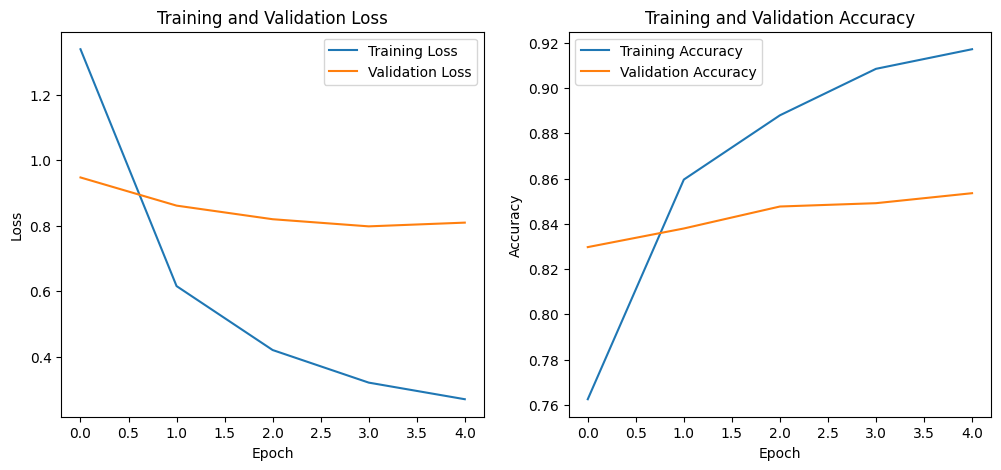

In [ ]:
# Plotting losses and accuracies
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


In [ ]:
# Function to translate new sentences
def translate_sentence(model, tokenizer, sentence):
    model.eval()
    inputs = tokenizer([sentence], return_tensors="pt", padding=True)
    translated = model.generate(**inputs)
    translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
    return translated_text

In [ ]:
# Test the translation function with a new sentence
test_sentence = "The weather is nice today."
print("Original sentence:", test_sentence)
print("Translated sentence:", translate_sentence(model, tokenizer, test_sentence))

Original sentence: The weather is nice today.
Translated sentence: La météo est belle aujourd'hui.
